# PINN Example: Learning the Immune Response Dynamics

In this experiment, we use a **Physics-Informed Neural Network (PINN)** to learn the dynamics of the **immune response** governed by a system of ordinary differential equations (ODEs). These equations describe the temporal evolution of pathogen and leukocyte concentrations during an infection process.

### Objective

The goal is to approximate the solution of the ODEs using a neural network trained only by the underlying **biological laws** represented as differential equations. This approach integrates data-driven learning with known mechanistic models.

### Key Features

- **Inputs:** Time values $ t \in [t_{\text{lower}}, t_{\text{upper}}]$
- **Outputs:** Neural network predictions of pathogen $C_p(t)$ and leukocyte $C_l(t)$ concentrations
- **Loss Function:** Combines data loss (when available) with physics loss derived from the residuals of the ODEs
- **Advantage:** Enforces biologically plausible behavior even with limited or noisy data

### Why PINNs?

PINNs allow for:
- Solving inverse problems (e.g., inferring parameters)
- Handling sparse or noisy measurements
- Preserving biological consistency through embedded ODE structure


In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle as pk
import matplotlib.pyplot as plt

## Defining Simulation Parameters and Time Domain

In this section, we define the **parameters** and the **time domain** used for training the Physics-Informed Neural Network (PINN). These values correspond to the biological and numerical configuration of the immune response model.

This setup prepares the temporal domain over which the PINN will learn to approximate the solution of the immune system equations.


In [13]:
# Define simulation parameters directly
k = 0.01        # Time step size
phi = 0.2          # Parameter φ
ksi = 0.0          # Parameter ξ
cb = 0.15          # Parameter c_b
C_nmax = 0.55      # Maximum value for concentration C_n
lambd_nb = 1.8     # Lambda for neutrophils to bacteria
mi_n = 0.2         # Natural death rate for neutrophils
lambd_bn = 0.1     # Lambda for bacteria to neutrophils
y_n = 0.1          # Neutrophil production rate
t_lower = 0.0      # Lower bound of the simulation time
t_upper = 5.0      # Upper bound of the simulation time

# Compute the number of time steps based on range and step size
size_t = int((t_upper - t_lower) / k)
print(f"Steps in time = {size_t}\n")

# Create a time tensor from t_lower to t_upper with step size k
#     requires_grad=True allows gradient tracking for autograd
t = torch.arange(t_lower, t_upper, k, requires_grad=True).reshape(-1, 1)

# Store a CPU copy of t for later use (if needed)
t_cpu = t


Steps in time = 500



## Reference Solution: Finite Difference Method (FDM)

This cell loads and plots the **reference solution** computed using the Finite Difference Method (FDM) for the immune response model. These solutions serve as a benchmark for evaluating the performance of the Physics-Informed Neural Network (PINN).

### Data Loading

Two `.pkl` files are loaded:
- `Cp`: Time evolution of pathogen concentration
- `Cl`: Time evolution of leukocyte (immune cell) concentration

These were generated by numerically solving the system of ODEs using traditional FDM techniques with the same parameters defined earlier.


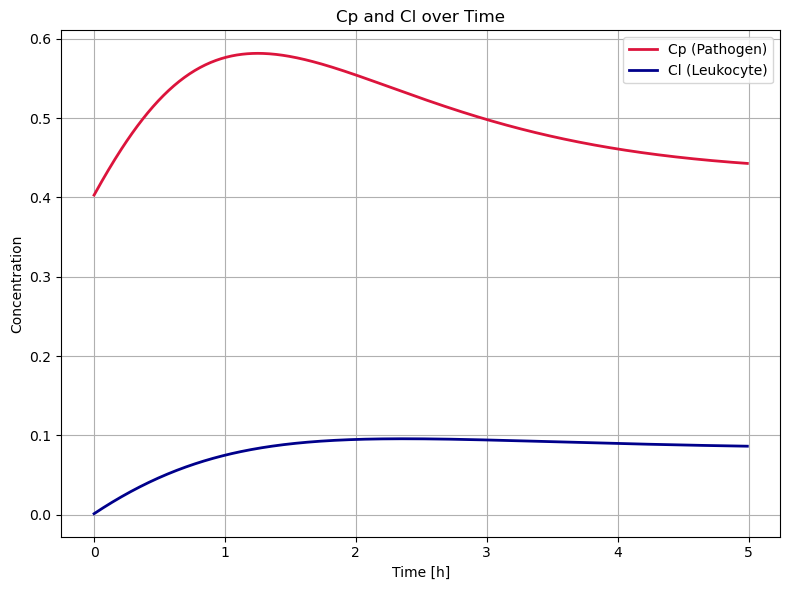

In [14]:
# Load pathogen concentration (Cp) over time from a Finite Difference Method (FDM) simulation
with open(
    "./Cp__k--0.01__phi--0.2__ksi--0.0001__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--5.0.pkl",
    "rb",
) as f:
    Cp = pk.load(f)

# Load leukocyte concentration (Cl) over time from the same FDM simulation
with open(
    "./Cl__k--0.01__phi--0.2__ksi--0.0001__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--5.0.pkl",
    "rb",
) as f:
    Cl = pk.load(f)

# Convert the time tensor t to a 1D NumPy array for plotting
# (detach() is used in case t was created with requires_grad=True for autograd)
t_np = t.detach().numpy().flatten()

# Create a new figure for the plot
plt.figure(figsize=(8, 6))

# Plot Cp (Pathogen concentration) over time
plt.plot(t_np, Cp, label="Cp (Pathogen)", color="crimson", linewidth=2)

# Plot Cl (Leukocyte concentration) over time
plt.plot(t_np, Cl, label="Cl (Leukocyte)", color="darkblue", linewidth=2)

# Label axes and add title
plt.xlabel("Time [h]")
plt.ylabel("Concentration")
plt.title("Cp and Cl over Time")

# Add legend and grid
plt.legend()
plt.grid(True)

# Optimize spacing and display the plot
plt.tight_layout()
plt.show()


## Neural Network Architecture for PINN

In this step, we define the architecture of the neural network used in the Physics-Informed Neural Network (PINN). This network serves as a universal function approximator to learn the solution of the immune response equations over time.

### Architecture Details

The model is constructed using `torch.nn.Sequential`, which stacks layers in a feed-forward manner:

- **Input Layer:**
  - Takes a single scalar input $ t $ (time)
  - Projects it to 32 hidden neurons

- **Hidden Layers:**
  - 4 fully connected layers with 32 neurons each
  - **Activation function:** `Tanh` is applied after each layer to introduce non-linearity and ensure smooth approximations — useful for modeling continuous biological processes

- **Output Layer:**
  - Maps the final 32 hidden features to **2 outputs**, representing the predicted concentrations of:
    - $ C_p(t) $: Pathogen
    - $ C_l(t) $: Leukocyte (immune response)



In [15]:
# Define the neural network architecture explicitly using nn.Sequential
# Input: time t (1 feature)
# Output: predictions for Cp and Cl (2 features)

model = nn.Sequential(
    # Input layer: 1 -> 32 neurons, followed by Tanh activation
    nn.Linear(1, 32),
    nn.Tanh(),

    # Hidden layer: 32 -> 32 neurons
    nn.Linear(32, 32),
    nn.Tanh(),

    # Hidden layer: 32 -> 32 neurons
    nn.Linear(32, 32),
    nn.Tanh(),

    # Hidden layer: 32 -> 32 neurons
    nn.Linear(32, 32),
    nn.Tanh(),

    # Output layer: 32 -> 2 neurons (representing Cp and Cl)
    nn.Linear(32, 2)
)

# Print model architecture summary
print(model)
print("Number of tunable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=2, bias=True)
)
Number of tunable parameters:  3298


## Generating Training Points for PINN Models

In this section, we define two functions that prepare the **training data** required for a **Physics-Informed Neural Network (PINN)**.
These datasets represent:

1. The **initial conditions** (known values at ( t = 0 )), and
2. The **collocation points** where the PDE residuals will be enforced.

---

### 🔹 `generate_initial_points(num_points, device)`

This function generates the **initial condition points** for the system of PDEs or ODEs.

It constructs two tensors:

* **Time tensor** ( t = 0 ) for all points, representing the initial instant of the system.
* **Concentration tensor** ( C_0 = [C_l(0), C_p(0)] ), representing the starting state of the biological or chemical system.

#### Parameters

* `num_points` — Number of initial data points to generate.
* `device` — The computation device (`cpu` or `cuda`) used to store the tensors.

#### Returns

A tuple of tensors:

* `t`: Tensor of shape ([N, 1]), representing the initial time values, all set to zero, with `requires_grad=True`.
* `C0`: Tensor of shape ([N, 2]), containing:

  * ( C_l(0) = 0.0 )
  * ( C_p(0) = 0.4 )

#### Description

This function defines the **starting state** of the system — for example:

* ( C_l ): leukocyte concentration (initially zero)
* ( C_p ): pathogen concentration (introduced at 0.4)

These values serve as **boundary conditions** for training the PINN model to respect the known initial behavior of the system.

---

### 🔹 `generate_pde_points(num_points, device, t_lim)`

This function generates **collocation points** in time used to enforce the **PDE residuals** during training.

Each point corresponds to a random time ( t \in [0, t_{\text{lim}}) ) where the model must satisfy the underlying differential equations.

#### Parameters

* `num_points` — Number of collocation (training) points to generate.
* `device` — Device (`cpu` or `cuda`) used for tensor allocation.
* `t_lim` — Upper time limit defining the sampling interval for ( t ).

#### Returns

A tuple of tensors:

* `t`: Tensor of shape ([N, 1]), containing uniformly sampled times in ([0, t_{\text{lim}})), with `requires_grad=True`.
* `C`: Tensor of shape ([N, 2]), initialized as zeros, serving as placeholders for the predicted concentrations ([C_l, C_p]).

#### Description

These points are used during the PINN training phase to **evaluate PDE residuals**.
By sampling ( t ) randomly across the domain, the network learns to satisfy the governing equations at multiple locations, ensuring smooth and physically consistent dynamics.

---

Together, these two functions define the **data generation step** for the PINN:

* `generate_initial_points` → ensures the model starts from known initial values.
* `generate_pde_points` → enforces physical consistency through PDE residuals across the time domain.



In [16]:
from fisiocomPinn.Net import *
from fisiocomPinn.Trainer import *
from fisiocomPinn.Loss import *

def generate_initial_points(num_points, device):

    # Initialize time tensor with zeros (t = 0 for all points)
    t = torch.zeros(num_points, 1, dtype=torch.float32)

    # Initialize concentration of the first component (e.g., ligand) at t=0
    Cl = torch.zeros_like(t).to(device)

    # Initialize concentration of the second component (e.g., pathogen) at t=0
    # Cp(0) = 0.4 represents an initial pathogen concentration
    Cp = torch.zeros_like(t).to(device) + 0.4

    # Enable autograd for time and move tensors to the desired device
    # Return both time and concatenated concentrations
    return (
        t.requires_grad_(True).to(device),
        torch.cat([Cl, Cp], dim=1),
    )


def generate_pde_points(num_points, device, t_lim):

    # Uniformly sample time points t ∈ [0, t_lim)
    t = torch.rand(num_points, 1, dtype=torch.float32) * t_lim

    # Initialize corresponding concentration tensor with zeros
    # Each row will represent a pair [Cl, Cp] at a given time t
    C = torch.zeros((len(t), 2), dtype=torch.float32)

    # Enable autograd for time to allow computation of time derivatives via autograd
    # Move all tensors to the specified device (CPU or GPU)
    return (
        t.requires_grad_(True).to(device),
        C.to(device),
    )


## Defining Initial Conditions and ODE Residuals

In this section, we define two key components used to construct the **PINN loss function**:  
(1) the **initial condition**, and  
(2) the **differential equation residuals** that enforce the immune system dynamics.

---

### 🔹 `initial_condition(t)`

This function encodes the known initial state of the system at $ t = 0 $:

- $ C_l(0) = 0 $: No leukocytes are present initially.
- $ C_p(0) = 0.4 $: The pathogen is introduced with initial concentration 0.4.

The function returns a tensor of shape $[N, 2]$, where each row is $[C_l, C_p]$ at a given time.

---

### 🔹 `ode(t, model)`

This function defines the **residuals** of the governing ODEs, based on the model predictions:

- The neural network is evaluated at time $ t $ to predict concentrations:
  - $ C_l(t) $: Leukocyte
  - $ C_p(t) $: Pathogen

- Using PyTorch's `autograd`, it computes:
  - $ \frac{dC_p}{dt} $
  - $ \frac{dC_l}{dt} $

- The function returns the **residuals** (difference between both sides), which should be close to zero if the model satisfies the physics.

---

These functions are essential to build the **PINN loss**, ensuring the network adheres to the initial state and respects the immune dynamics throughout training.


In [17]:
def initial_condition(t, model):
    """
    Notes
    -----
    This function acts as a wrapper that applies the trained (or untrained)
    neural network `model` to the initial time points `t`. It is commonly used
    in PINN frameworks to compute the **initial condition loss**, enforcing that:
        model(0) ≈ known_initial_state
    """
    return model(t)

# Define the ODE residuals based on the model's prediction
def ode(t, model):
    # Predict concentrations Cl and Cp using the neural network
    C = model(t)  # C[:, 0] = Cl, C[:, 1] = Cp

    # ----------------------
    # Compute dCp/dt
    dCp_dt = torch.autograd.grad(
        C[:, 1],                      # Cp output
        t,                           # input with respect to which we differentiate
        grad_outputs=torch.ones_like(C[:, 1]),  # vector-Jacobian product
        create_graph=True,           # enable higher-order derivatives
        retain_graph=True            # keep computation graph for dCl/dt
    )[0]

    # ODE residual for Cp(t) based on the original equation:
    # dCp/dt = ((cb - λ_nb * Cl) * Cp) / φ
    Cp_eq = (cb - lambd_nb * C[:, 0]) * C[:, 1] / phi - dCp_dt.squeeze()

    # ----------------------
    # Compute dCl/dt
    dCl_dt = torch.autograd.grad(
        C[:, 0],                      # Cl output
        t,
        grad_outputs=torch.ones_like(C[:, 0]),
        create_graph=True,
        retain_graph=True
    )[0]

    # ODE residual for Cl(t):
    # dCl/dt = (y_n * Cp * (C_nmax - Cl) - (λ_bn * Cp + μ_n) * Cl) / φ
    Cl_eq = (
        y_n * C[:, 1] * (C_nmax - C[:, 0]) -
        (lambd_bn * C[:, 1] + mi_n) * C[:, 0]
    ) / phi - dCl_dt.squeeze()

    # Return the ODE residuals as a single tensor with shape [N, 2]
    return torch.cat([Cl_eq.reshape(-1, 1), Cp_eq.reshape(-1, 1)], dim=1)


## The `Trainer` Class — Overview

The **`Trainer`** object manages all stages of model optimization. It combines multiple custom losses, monitors validation metrics, and automatically restores the best model using **early stopping**.

---

### 🧩 Key Components

| Component                | Description                                                                                                       |
| ------------------------ | ----------------------------------------------------------------------------------------------------------------- |
| **`shuffle_data()`**     | Randomly shuffles input arrays to prevent order bias during training.                                             |
| **`train_test_split()`** | Divides data into training and validation subsets; supports both ratio (e.g. 0.2) or fixed count splits.          |
| **`add_loss()`**         | Registers additional loss components (e.g., data loss, PDE residual loss, boundary loss) with optional weighting. |
| **`__init__()`**         | Initializes core training parameters: epochs, patience, optimizer, validation ratio, and device setup.            |
| **`train()`**            | Main training loop that performs backpropagation, optimization, validation, and early stopping.                   |

---

### ⚙️ Early Stopping Mechanism

The **early stopping** logic helps prevent overfitting:

1. Tracks the **minimum validation loss** (`val_min`).
2. If the validation loss does not improve by at least `tolerance` for `patience` iterations:

   * Training stops early.
   * The model parameters revert to the **best performing state**.

This ensures efficient and stable convergence without wasting computation.

---

### 📈 Training Workflow Summary

| Step | Description                                                                              |
| ---- | ---------------------------------------------------------------------------------------- |
| 1    | **Device setup:** Automatically select GPU if available.                                 |
| 2    | **Optimizer:** Initialize Adam with a suitable learning rate.                            |
| 3    | **Trainer setup:** Configure epochs, patience, and validation fraction.                  |
| 4    | **Loss registration:** Add custom loss terms (e.g., data, PDE, boundary).                |
| 5    | **Training loop:** Compute total weighted loss and backpropagate.                        |
| 6    | **Validation:** Periodically check performance on held-out data.                         |
| 7    | **Early stopping:** Stop training and restore the best model if overfitting is detected. |

---

### 🧠 Conceptual View

This training structure supports **Physics-Informed Neural Networks (PINNs)** or **hybrid data-driven models** by combining multiple objectives:

$
\mathcal{L}*{\text{total}} =
w_1 \mathcal{L}*{\text{data}} +
w_2 \mathcal{L}*{\text{physics}} +
w_3 \mathcal{L}*{\text{IC/BC}}
$

where:

* ($ \mathcal{L}_{\text{data}} $): fits the model to observed data,
* ($ \mathcal{L}_{\text{physics}} $): enforces PDE or ODE constraints,
* ($ \mathcal{L}_{\text{IC/BC}} $): enforces initial/boundary conditions.

This modular design allows flexible integration of different physical and empirical loss functions during training.

In [18]:
# ==============================================================
# Device Configuration
# ==============================================================

# Check if a CUDA-compatible GPU is available.
# If so, use it as the computation device to accelerate training.
if torch.cuda.is_available():
    device = torch.device("cuda")

# ==============================================================
# Optimizer Definition
# ==============================================================

# Define the optimizer used to update the neural network parameters.
# Here, we use Adam (Adaptive Moment Estimation), which adapts the learning
# rate for each parameter individually based on first- and second-moment estimates.
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==============================================================
# Trainer Object Initialization
# ==============================================================

# Create a Trainer object that manages the full training loop:
# - Handles data splitting (training/validation)
# - Tracks and applies multiple loss functions
# - Implements early stopping with patience and tolerance
# - Prints training progress at regular intervals
trainer = Trainer(
    n_epochs=10000,     # Total number of epochs (training iterations over the full dataset)
    model=model,        # Neural network model to be trained
    device=device,      # Target device (CPU or GPU)
    patience=2750,      # Number of validation checks to wait before early stopping
    tolerance=0.01,     # Relative improvement threshold required to reset patience
    validation=0.2,     # Fraction of data used for validation (20%)
    optimizer=optimizer,# Optimizer instance (Adam)
    print_steps=1000,   # Frequency (in steps) to print progress to the console
)



## The `LOSS` Object — A Modular Loss Manager for PINNs

The **`LOSS`** class is a flexible and extensible object designed to handle **data-driven** and **physics-informed** loss components in a unified framework.
It supports multiple loss criteria (e.g., MSE, RMSE, L2, KL Divergence) and integrates seamlessly into the custom `Trainer` class.

This modular design allows researchers to **combine different loss functions** and **balance their contributions** when training hybrid or physics-informed neural networks (PINNs).

---

### 🔹 Overview

The `LOSS` object provides a consistent interface to:

1. **Generate data batches** (from datasets or dynamically sampled points),
2. **Evaluate model predictions**, and
3. **Compute loss values** using a specified criterion.

It extends `torch.nn.Module`, making it fully compatible with the PyTorch ecosystem.

---

### 🔹 Available Loss Criteria

At initialization, the user can specify a desired **criterium** (loss type).
The available options are defined in the `loss_map` dictionary:

| Loss Type                | Description                           |
| ------------------------ | ------------------------------------- |
| **MAE**                  | Mean Absolute Error                   |
| **MSE**                  | Mean Squared Error                    |
| **RMSE**                 | Root Mean Squared Error               |
| **KLDivergenceLoss**     | Kullback-Leibler Divergence           |
| **CosineSimilarityLoss** | Cosine-based distance between vectors |
| **LPthLoss**             | Generalized ( L_p ) norm loss         |
| **L2**                   | Normalized Euclidean distance         |
| **L2_squared**           | Squared normalized Euclidean distance |


Each criterion is implemented as a **lambda function** within `loss_map` and applied dynamically during training.


In [19]:

# ==============================================================
# Define Batch Size
# ==============================================================

# The batch size corresponds to the total number of time samples (t).
# Each batch will be used to compute the loss at different time points.
batch_size = len(t)

# ==============================================================
# INITIAL CONDITION LOSS
# ==============================================================

# Create a LOSS object for the initial condition term.
# This loss enforces that the model output at t = 0 matches the known
# initial concentrations or state values of the system.
init_loss = LOSS(
    device=device,                  # Computation device (CPU/GPU)
    name="FsisiocomPIIN Inital",    # Name of the loss for tracking/logging
    batch_size=batch_size,          # Number of samples per batch
)

# Define the function that generates the training points for this loss.
# Here, 'generate_initial_points' produces (t, [Cl, Cp]) pairs
# where t = 0 and [Cl(0), Cp(0)] are known initial conditions.
init_loss.setBatchGenerator(generate_initial_points)

# Define the evaluation function that computes the model predictions.
# 'initial_condition' simply evaluates model(t) to obtain the predicted state
# at the given initial time points.
init_loss.setEvalFunction(initial_condition)

# Register the initial condition loss in the Trainer object.
# The weight (10) scales its influence relative to other losses
# in the total loss function:
#     L_total = 10 * L_initial + 1 * L_pde + ...
trainer.add_loss(init_loss, 10)

# ==============================================================
# PDE RESIDUAL LOSS
# ==============================================================

# Create another LOSS object for the PDE residual.
# This loss enforces the underlying physical dynamics defined by the
# differential equations, ensuring the model satisfies:
#     dC/dt = f(C, t)
pde_loss = LOSS(
    device=device,               # Computation device (CPU/GPU)
    name="FsisiocomPIIN PDE",    # Name of the loss component
    batch_size=batch_size,       # Number of collocation points
)

# Define the function that generates random time points (t ∈ [0, t_upper))
# for enforcing the PDE residuals across the temporal domain.
# 'generate_pde_points' provides the collocation points for training.
pde_loss.setBatchGenerator(generate_pde_points, t_upper)

# Define the evaluation function for this loss term.
# 'ode' computes the residuals of the governing ODE/PDE using autograd,
# ensuring that the neural network satisfies the differential equations.
pde_loss.setEvalFunction(ode)

# Register the PDE residual loss in the Trainer object with default weight = 1.
trainer.add_loss(pde_loss)

## Training the PINN Model

Once all loss components (e.g., **initial condition loss** and **PDE residual loss**) are registered, we begin the **training phase** using the `Trainer` class.

```python
model, loss_dict = trainer.train()
```

### 🔹 What Happens During Training

1. **Forward Pass:**

   * The model is evaluated on data batches or collocation points.
   * Each registered `LOSS` object computes its respective contribution:

     * ( \mathcal{L}_{IC} ): initial condition consistency
     * ( \mathcal{L}_{PDE} ): differential equation residual
     * (and optionally, ( \mathcal{L}*{data} ) or ( \mathcal{L}*{BC} ))

2. **Total Loss Computation:**
   [
   \mathcal{L}_{\text{total}} =
   \sum_i w_i , \mathcal{L}_i
   ]
   where each loss ( \mathcal{L}_i ) is weighted by its importance ( w_i ).

3. **Backward Pass & Optimization:**

   * Gradients of the total loss are computed using PyTorch’s **autograd**.
   * The optimizer (Adam) updates the model parameters.

4. **Validation & Early Stopping:**

   * Every few steps, the model is evaluated on validation data.
   * If no improvement is observed for `patience` iterations, training stops early.
   * The best model state (lowest validation loss) is restored automatically.

---

### 🔹 Outputs

* **`model`** → The trained neural network ready for inference or further evaluation.
* **`loss_dict`** → A Python dictionary containing recorded loss values over training, e.g.:



In [20]:
# ==============================================================
# Model Training Execution
# ==============================================================

# Launch the training loop using the Trainer object.
# --------------------------------------------------------------
# The trainer internally:
#   1. Iterates over all epochs and batches.
#   2. Computes each registered loss term (e.g., initial condition, PDE residuals).
#   3. Aggregates them into a total weighted loss.
#   4. Performs backpropagation and optimizer updates.
#   5. Optionally evaluates validation loss for early stopping.
#
# Returns:
#   model      → The trained neural network with optimized parameters.
#   loss_dict  → A dictionary containing the loss history for each term,
#                including validation losses (if enabled).
model, loss_dict = trainer.train()


Iteration 0: total loss 8.0055, losses: [7.737024307250977, 0.2684726119041443], time: 2.6538s
Iteration 1000: total loss 0.0858, losses: [0.06380840390920639, 0.02194507233798504], time: 0.0024s
Iteration 2000: total loss 0.0522, losses: [0.04505942761898041, 0.007179661188274622], time: 0.0024s
Iteration 3000: total loss 0.0725, losses: [0.05503421276807785, 0.01744196005165577], time: 0.0022s
Iteration 4000: total loss 0.0267, losses: [0.020964333787560463, 0.005722932051867247], time: 0.0022s
Iteration 5000: total loss 0.0211, losses: [0.018514113500714302, 0.0025656362995505333], time: 0.0021s
Iteration 6000: total loss 0.0256, losses: [0.02025204710662365, 0.005315941292792559], time: 0.0022s
Iteration 7000: total loss 0.0236, losses: [0.018031125888228416, 0.005607873201370239], time: 0.0025s
Iteration 8000: total loss 0.0229, losses: [0.018444448709487915, 0.004495151806622744], time: 0.0022s
Iteration 9000: total loss 0.0261, losses: [0.02050107531249523, 0.005565378814935684]

## Learning Curve

This plot shows how the different loss components evolve during PINN training:

- **PDE loss:** measures how well the network satisfies the differential equations.
- **Initial loss:** measures the error in the initial condition.
- **Data loss:** measures the difference between the model prediction and the simulated data (FDM).

This helps us track whether the model is converging properly.


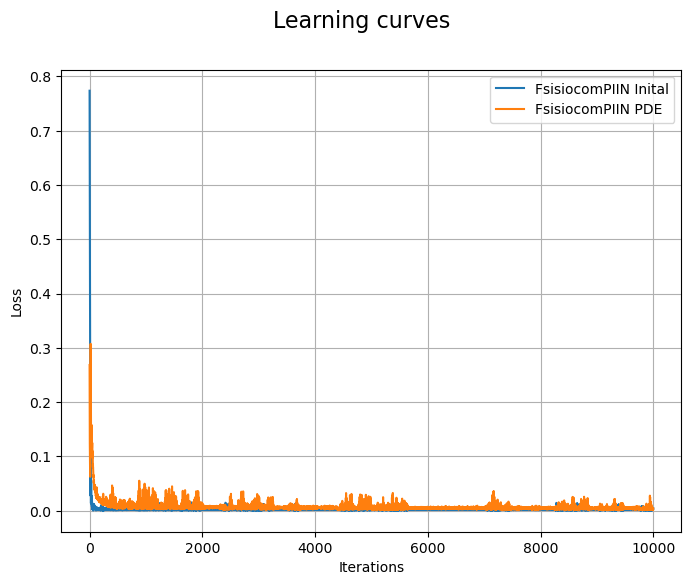

In [21]:
# ==============================================================
# Plotting the Learning Curves
# ==============================================================

# Create a new figure object with a specified size (width=8, height=6 inches).
# This figure will hold all subplots and titles for visualization.
fig = plt.figure(figsize=[8, 6])

# Add a main (global) title for the figure.
# This describes the overall content of the plot — the model’s learning progress.
fig.suptitle("Learning curves", fontsize=16)

# Create a single subplot (1 row × 1 column, first position).
# 'ax' represents the plotting area (axes) where the loss curves will be drawn.
ax = fig.add_subplot(1, 1, 1)

# Label the x- and y-axes to indicate what the plot represents.
ax.set_xlabel("Iterations")   # The training iteration or epoch number.
ax.set_ylabel("Loss")         # The loss value corresponding to each iteration.

# Iterate over all loss terms stored in 'loss_dict'.
# Each key corresponds to a specific loss function tracked during training,
# e.g., "FsisiocomPIIN Initial", "FsisiocomPIIN PDE", or "val" for validation loss.
for loss in loss_dict:

    # Skip the validation loss to plot it separately if desired.
    # Here we only plot the training-related losses.
    if not loss == "val":
        ax.plot(
            range(len(loss_dict[loss])),  # x-axis: iteration indices
            loss_dict[loss],              # y-axis: loss values
            label=loss,                   # Label for legend (name of loss term)
        )

# Add a grid to improve readability and visual reference of the curves.
ax.grid()

# Display the legend that identifies each plotted curve.
ax.legend()

# Render the plot to the screen.
plt.show()


## Model Evaluation: Error Metrics

In this step, we evaluate the performance of the trained PINN by comparing its predictions to the reference solution obtained via the Finite Difference Method (FDM).

### Metrics Computed:
- **RMSE (Root Mean Squared Error):**  
  Measures the average deviation between the PINN predictions and the reference values for both $ C_l(t) $ and $ C_p(t) $.

- **Maximum Absolute Error:**  
  Captures the largest pointwise error across the entire time interval, reported separately for $ C_l $ and $ C_p $.

These metrics help assess how accurately the PINN learned the immune response dynamics over time.


In [24]:
# Evaluate the model without tracking gradients (inference mode)
with torch.no_grad():
    # Predict concentrations using the trained PINN
    Cl_pinn, Cp_pinn = model(t.to(device)).split(1, dim=1)

# Compute RMSE (Root Mean Squared Error) between PINN and FDM predictions
rmse = np.mean(
    [
        ((Cl_p - Cl_f) ** 2 + (Cp_p - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(Cl_pinn.to("cpu"), Cp_pinn.to("cpu"), Cl, Cp)
    ]
)

# Compute maximum absolute error for each output separately
max_ae = np.max(
    [
        [((Cl_p - Cl_f) ** 2) ** 0.5, ((Cp_p - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(Cl_pinn.to("cpu"), Cp_pinn.to("cpu"), Cl, Cp)
    ]
)

# Print the error metrics with more informative labels
print(f"Root Mean Squared Error : {rmse:.4f}")
print(f"Maximum Absolute Error : {max_ae}")


Root Mean Squared Error : 0.0057
Maximum Absolute Error : 0.012517333030700684


## Comparing PINN Predictions with Reference Solutions

This figure compares the PINN and FisiocomPINN predictions with the Finite Difference Method (FDM) reference solutions for both pathogen and leukocyte concentrations.

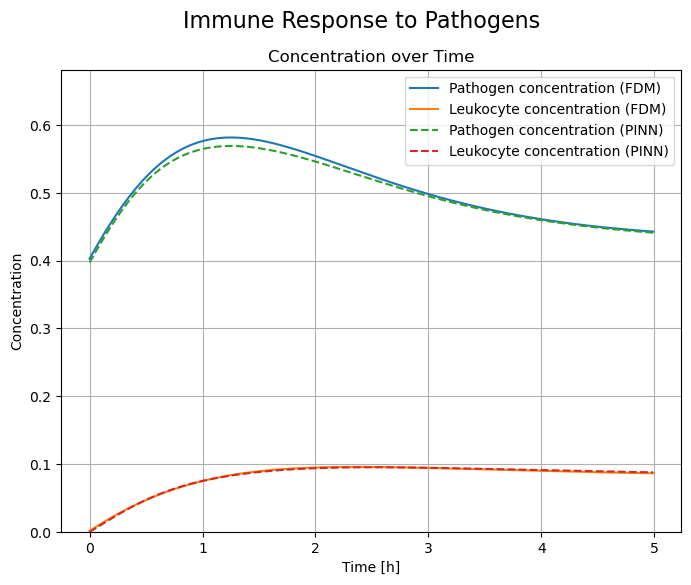

In [27]:
# ==============================================================
# ✅ Plotting the PINN and Reference Model Results
# ==============================================================

# Create a new figure window with a defined size (8 inches wide × 6 inches tall)
# This will contain the plots comparing model predictions and reference solutions.
fig = plt.figure(figsize=[8, 6])

# Add a descriptive title to the overall figure
fig.suptitle("Immune Response to Pathogens", fontsize=16)

# --------------------------------------------------------------
# Define vertical (y-axis) range for all plots
# --------------------------------------------------------------

# Set the lower bound for the concentration axis
vmin = 0

# Compute the upper bound dynamically as the maximum value among
# the leukocyte (Cl) and pathogen (Cp) reference concentrations.
# This ensures all curves fit within the same plot scale.
vmax = np.max([np.max(Cl), np.max(Cp)])

# --------------------------------------------------------------
# Create a single subplot for time-series visualization
# --------------------------------------------------------------

# Add one subplot (1 row × 1 column × position 1)
ax = fig.add_subplot(1, 1, 1)

# --------------------------------------------------------------
# Plot the reference (FDM) and model (PINN, FisiocomPINN) results
# --------------------------------------------------------------

# Plot the **Finite Difference Method (FDM)** reference solution for pathogen concentration
ax.plot(
    t.detach().numpy(), Cp, label="Pathogen concentration (FDM)"
)

# Plot the **FDM reference** for leukocyte concentration
ax.plot(
    t.detach().numpy(), Cl, label="Leukocyte concentration (FDM)"
)

# Plot the **PINN** prediction for pathogen concentration (dashed line)
ax.plot(
    t.detach().numpy(), Cp_pinn.to("cpu"), "--", label="Pathogen concentration (PINN)"
)

# Plot the **PINN** prediction for leukocyte concentration (dashed line)
ax.plot(
    t.detach().numpy(), Cl_pinn.to("cpu"), "--", label="Leukocyte concentration (PINN)"
)

# --------------------------------------------------------------
# Customize plot labels, limits, and presentation
# --------------------------------------------------------------

# Set the title of the subplot (distinct from the global figure title)
ax.set_title("Concentration over Time")

# Label the x-axis (time variable)
ax.set_xlabel("Time [h]")

# Label the y-axis (concentration variable)
ax.set_ylabel("Concentration")

# Set the limits for the y-axis to start at vmin (0)
# and end slightly above vmax for better visual spacing
ax.set_ylim(vmin, vmax + 0.1)

# Add a legend to distinguish each plotted curve
ax.legend()

# Enable grid lines to aid interpretation of the curves
ax.grid()

# Render and display the figure
plt.show()
